In [2]:
%load_ext autoreload
%autoreload 2
import os
from velocity_power.folding import SimulationParticles
import matplotlib.pyplot as plt
plt.style.use('niceplot2jay.mplstyle')

SNAPSHOT = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind0_gmc9/snapshot_550.hdf5'
simParticles = SimulationParticles.load_snapshot(SNAPSHOT)

In [81]:
# Bring back Voxelize.
import velocity_power.voxelize
simField = simParticles.voxelize_interp_to_field(Nsize=256)

Interpolating velocity field...


Padding:  0.035411309549151726 Lbox:  1.0708226190983035 Nsize:  548
Auto padding done. Time elapsed: 1.48 s


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 334119224 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	2.708e+08 exact calculations (R>Rmax),
	6.329e+07 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 334119224 numbers in 10214 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 58.4103 seconds
In the end, 0 in cpu_queue


Interpolation done. Time elapsed: 62.07 s


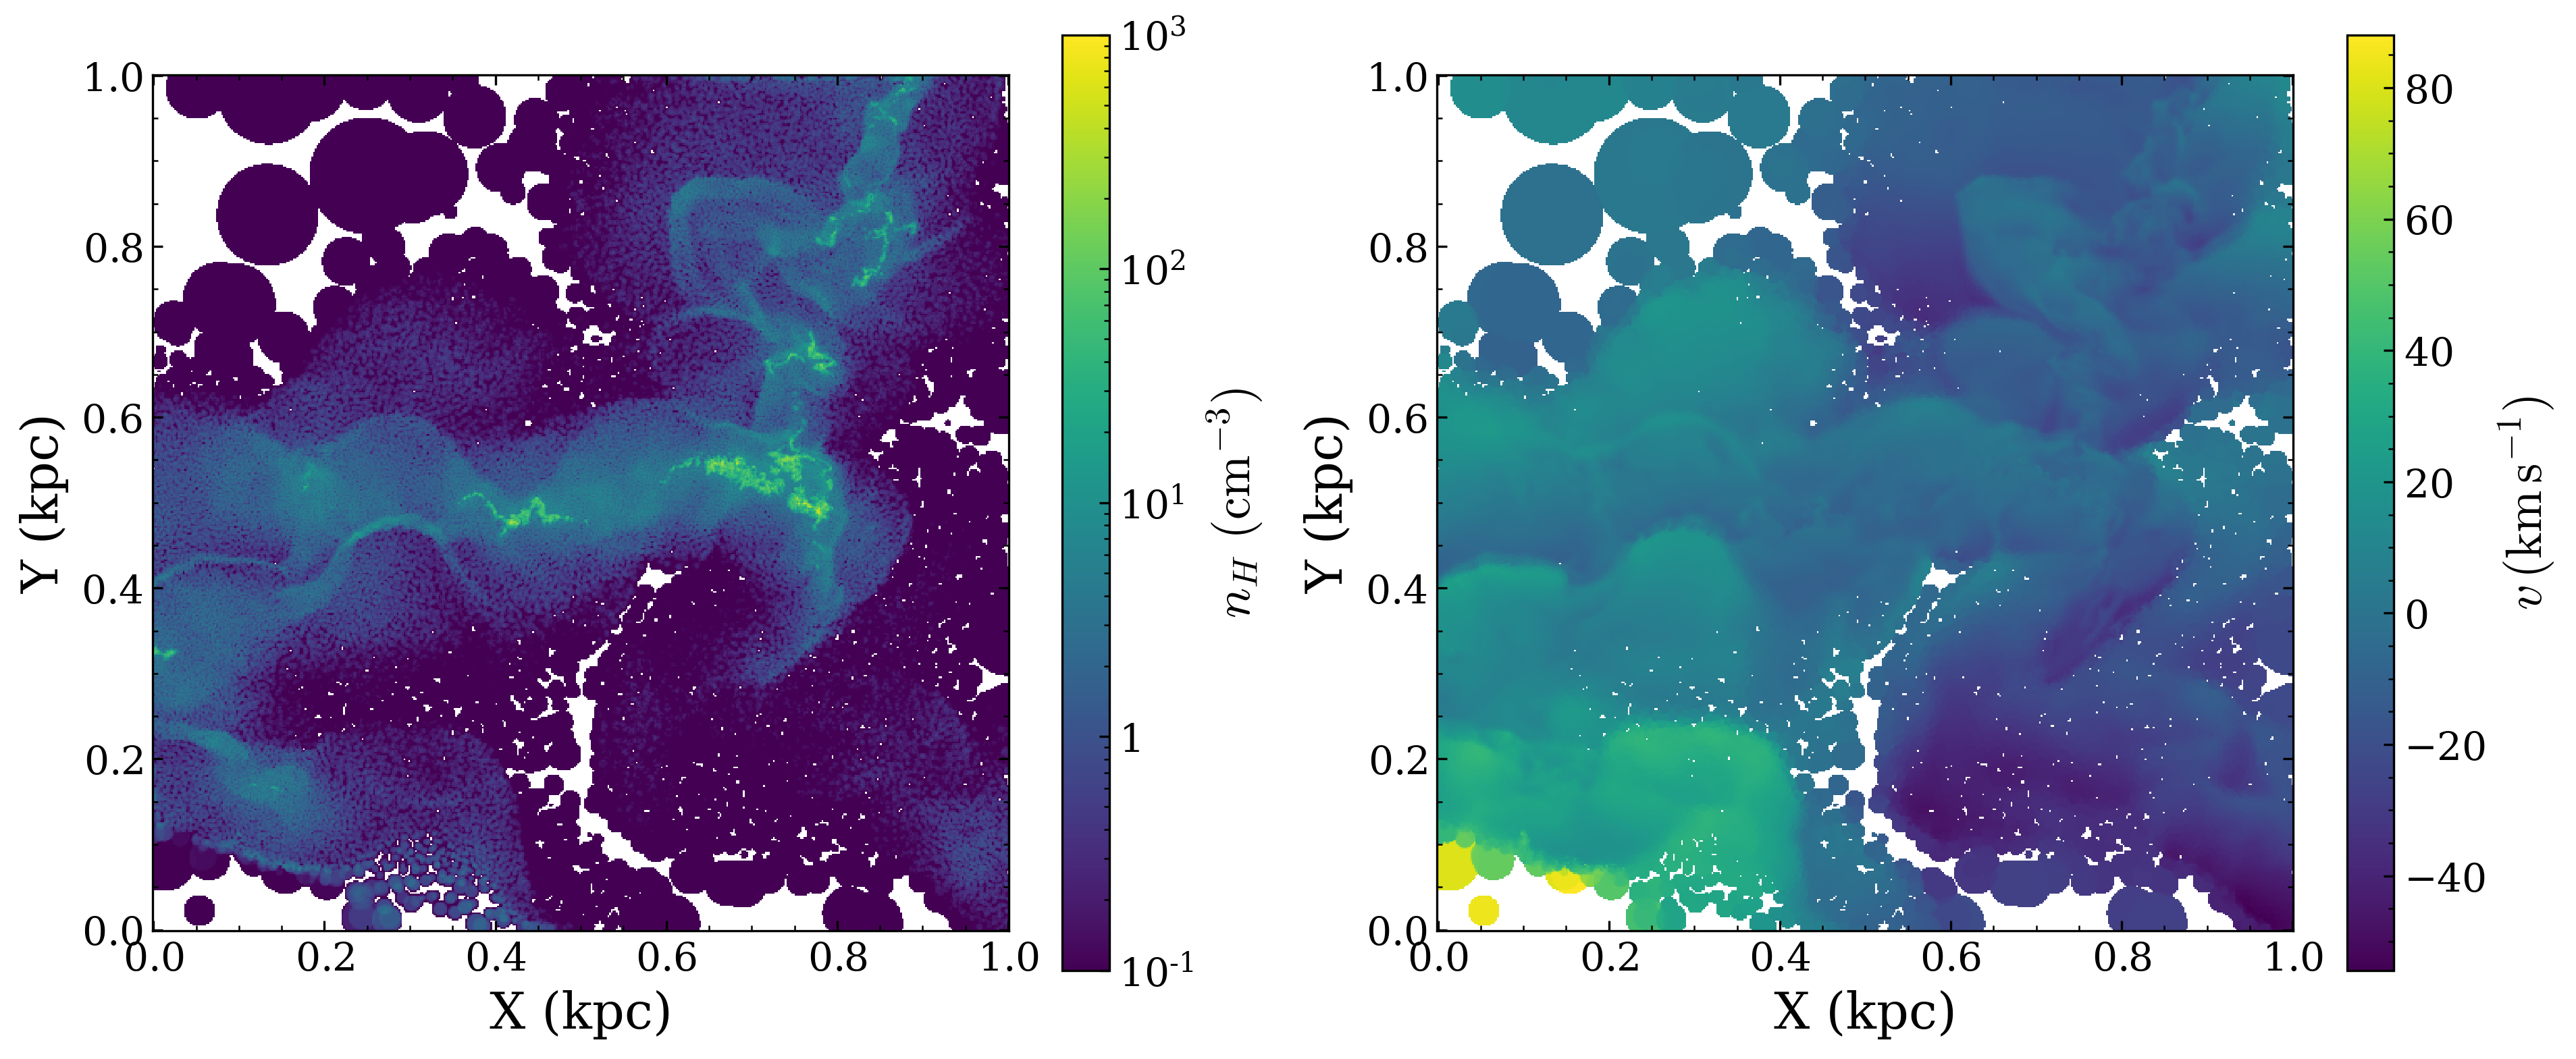

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simField.plot_density_slice(index=128, axis=2, ax=ax[0])
simField.plot_velocity_slice(component=0, index=128, axis=2, ax=ax[1])
plt.show()

## Interpolation: Histogram + ANN
To first use histogram to combine the momentum and mass, divide to get velocity in each cell, then use approximate nearest neighbour to fill in the empty cells.

In [5]:
simField = simParticles.interp_to_field(Nsize=256, eps=0.5)

Interpolating velocity field...


Padding complete. Padded box length: 1.0, Padded box size: 256
Data file saved.
Query file saved.



real	0m58.509s
user	0m57.104s
sys	0m1.194s


Approximate Nearest Neighbour complete. Time taken: 58.54 s.
Interpolation done. Time elapsed: 250.93 s


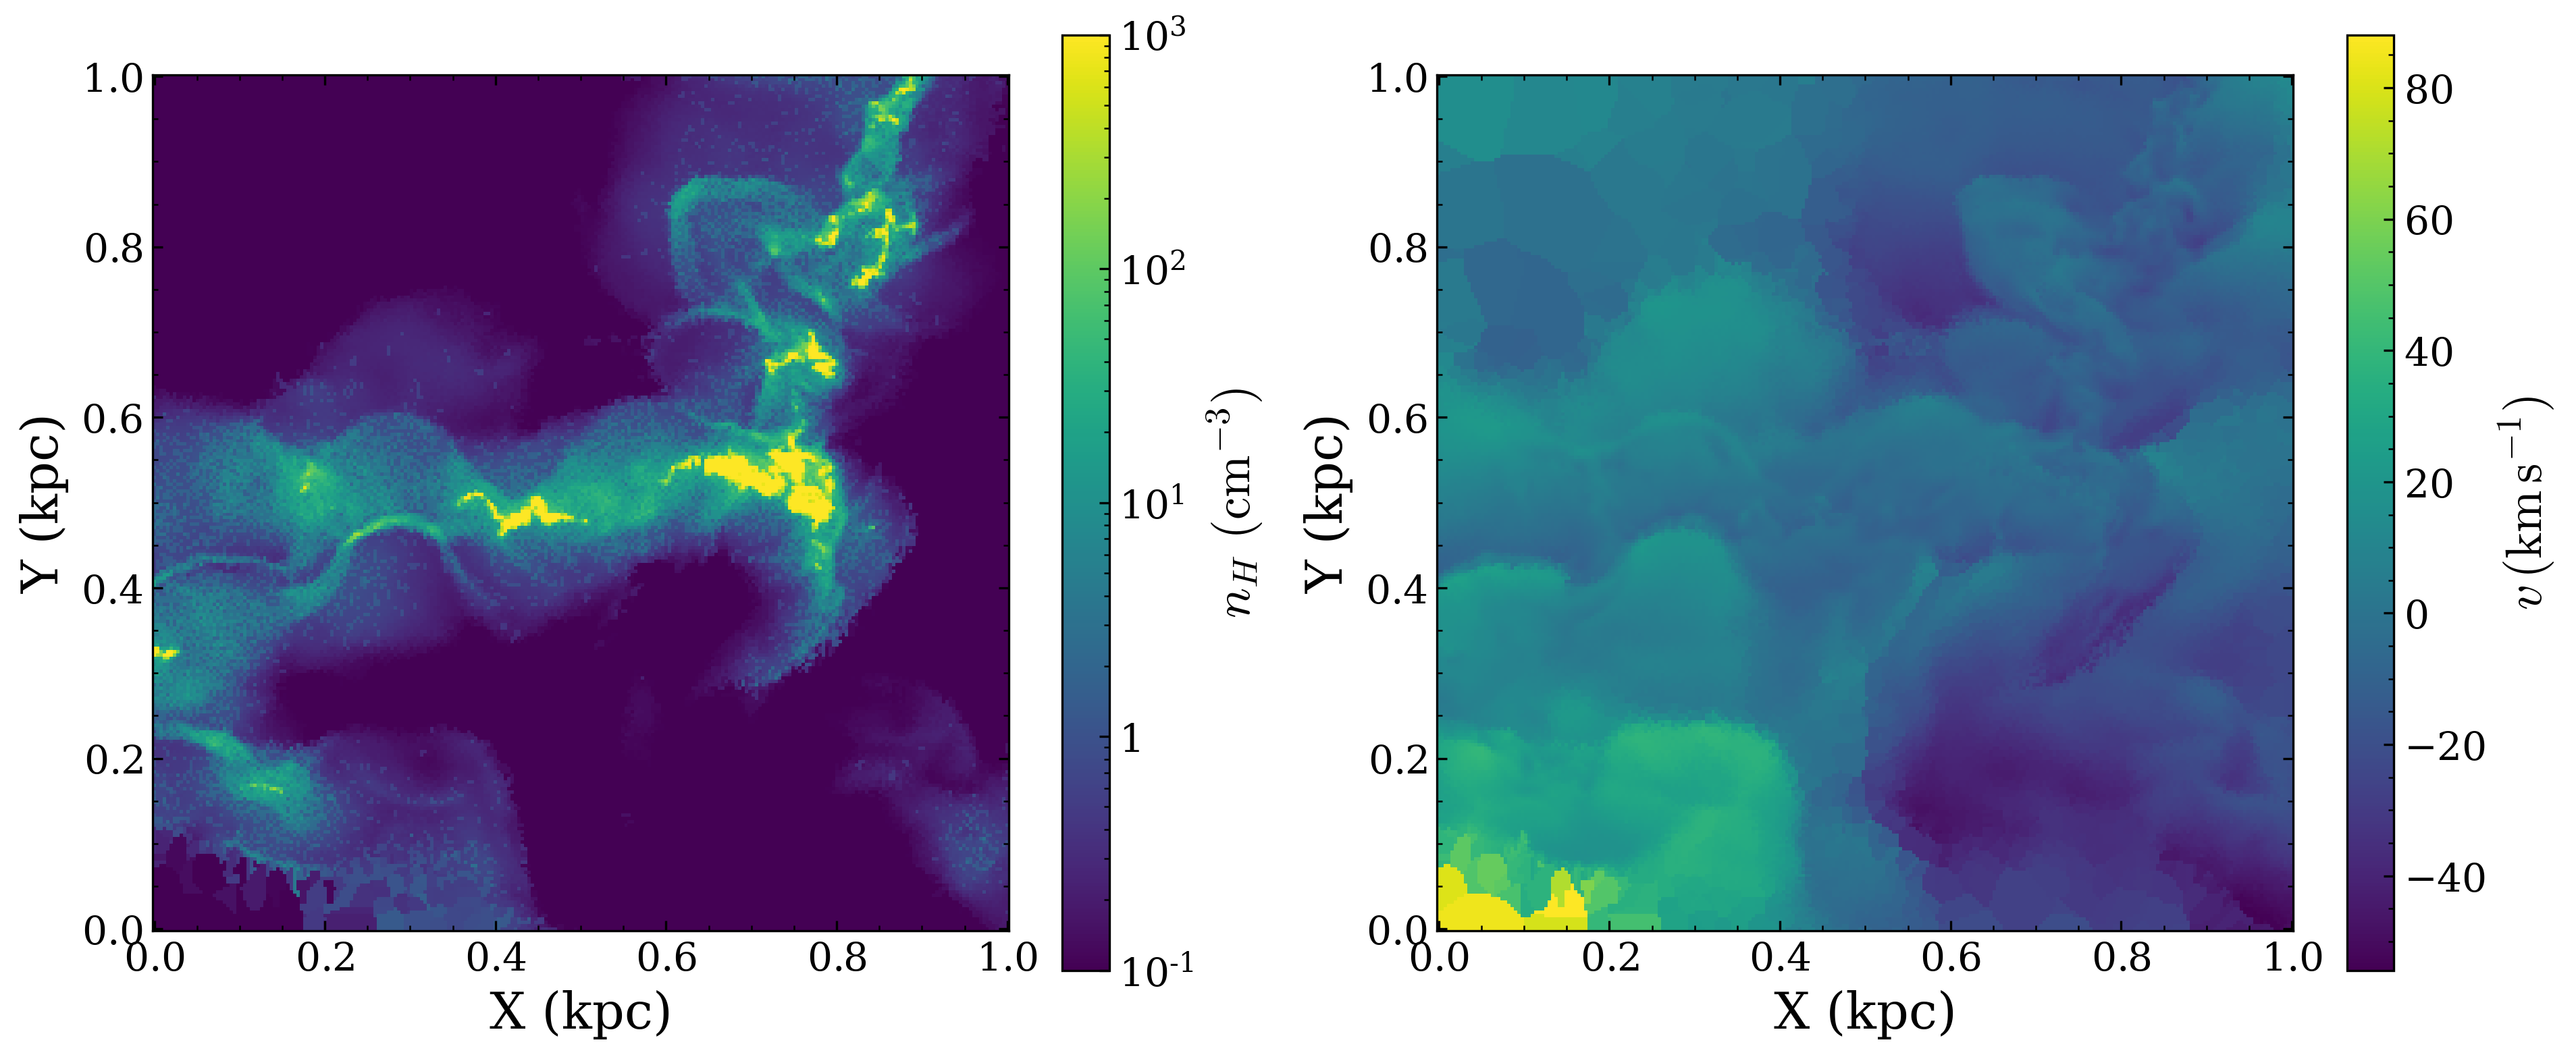

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simField.plot_density_slice(index=128, axis=2, ax=ax[0])
simField.plot_velocity_slice(component=0, index=128, axis=2, ax=ax[1])
plt.show()

In [7]:
from velocity_power.folding import check_conservation
check_conservation(simParticles, simField)

Total mass of particles: 0.00126
Total mass after interpolation: 3.975e+00
Total momentum of particles: [ 3.32786539e-17 -3.49623437e-16  4.52146187e-18]
Total momentum after interpolation: [-23.7154199    6.237815    -0.09684729]
Total kinetic energy of particles: 0.305
Total kinetic energy after interpolation: 2.456e+02


ANN cannot keep mass, momentum, and energy conserved when the resolution is significantly less than the particle scales. Now we test the conservation laws in greater resolution in a small region to see if things can get better. We try up to our target resolution: $\mathrm{Lcell}\sim1/16384=2^{14}$

In [51]:
simParticlesSmall = simParticles[(simParticles.pos[:,0] <= 65/128)
                                 & (simParticles.pos[:,1] <= 65/128)
                                 & (simParticles.pos[:,2] <= 65/128)
                                 & (simParticles.pos[:,0] >= 64/128)
                                 & (simParticles.pos[:,1] >= 64/128)
                                 & (simParticles.pos[:,2] >= 64/128)]
print(len(simParticlesSmall))
simParticlesSmall.Lbox = 1/128
# print(simParticlesSmall.__dict__)

47


In [52]:
simFieldSmall = simParticlesSmall.interp_to_field(Nsize=128, eps=0.2, auto_padding=False)

Interpolating velocity field...
Box length: 0.0078125, box size: 128
Data file saved.


Query file saved.



real	0m5.524s
user	0m5.318s
sys	0m0.093s


Approximate Nearest Neighbour complete. Time taken: 5.54 s.
Interpolation done. Time elapsed: 25.98 s


In [1]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simFieldSmall.plot_density_slice(index=64, axis=2, ax=ax[0], vmin=1, vmax=5)
simFieldSmall.plot_velocity_slice(component=0, index=64, axis=2, ax=ax[1])
plt.show()

NameError: name 'plt' is not defined

In [54]:
from velocity.power.folding import check_conservation
check_conservation(simParticlesSmall, simFieldSmall)

Total mass of particles: 6.36e-09
Total mass after interpolation: 6.432e-09
Total momentum of particles: [-2.95946953e-08  2.74641483e-08 -3.47089745e-08]
Total momentum after interpolation: [-2.97523670e-08  2.76247544e-08 -3.48986654e-08]
Total kinetic energy of particles: 2.25e-07
Total kinetic energy after interpolation: 2.253e-07


Take Lcell ~ 1/16384, Nsize = 128, Lbox = 1/128. Conservation of mass, momentum, and kinetic energy can hold to 1, 2, and 3 decimal places, respectively.

In [72]:
import numpy as np
np.min(simParticles.h(smoothing_rate=1)), 2**-14
# the radius of the particles is 50 times greater than cell length.

(1.2007644032615404e-06, 1.220703125e-06)

What if we double the size?

In [73]:
simParticlesSmall = simParticles[(simParticles.pos[:,0] <= 65/128)
                                 & (simParticles.pos[:,1] <= 65/128)
                                 & (simParticles.pos[:,2] <= 65/128)
                                 & (simParticles.pos[:,0] >= 63/128)
                                 & (simParticles.pos[:,1] >= 63/128)
                                 & (simParticles.pos[:,2] >= 63/128)]
print(len(simParticlesSmall))
simParticlesSmall.Lbox = 1/128

simFieldSmall = simParticlesSmall.interp_to_field(Nsize=128, eps=0.2, auto_padding=False)

from utils_folding import check_conservation
check_conservation(simParticlesSmall, simFieldSmall)

435
Interpolating velocity field...
Box length: 0.0078125, box size: 128
Data file saved.
Query file saved.



real	0m5.762s
user	0m5.556s
sys	0m0.088s


Approximate Nearest Neighbour complete. Time taken: 5.78 s.
Interpolation done. Time elapsed: 25.99 s
Total mass of particles: 5.9e-08
Total mass after interpolation: 9.058e-09
Total momentum of particles: [-4.10762243e-07  3.04547530e-07 -2.80338817e-07]
Total momentum after interpolation: [-6.50174384e-08  4.90685352e-08 -3.45809675e-08]
Total kinetic energy of particles: 3.06e-06
Total kinetic energy after interpolation: 4.713e-07


## Interpolation to blocks
Next we test the ANN interpolation to blocks.

In [7]:
blocksDecomp = simParticles.interp_to_blocks('output', nblocks=2, Nblock=64,
                                             eps=0.2)

Interpolating velocity field...
Padding complete. Padded box length: 0.6053542127440323, Padded box size: 76
Data file saved.
Query file saved.



real	0m1.144s
user	0m1.112s
sys	0m0.030s


Approximate Nearest Neighbour complete. Time taken: 1.16 s.
Interpolation done. Time elapsed: 5.74 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5745896494457838, Padded box size: 72
Data file saved.
Query file saved.



real	0m1.168s
user	0m1.141s
sys	0m0.025s


Approximate Nearest Neighbour complete. Time taken: 1.18 s.
Interpolation done. Time elapsed: 5.93 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5584916110132099, Padded box size: 70
Data file saved.
Query file saved.



real	0m1.053s
user	0m1.033s
sys	0m0.018s


Approximate Nearest Neighbour complete. Time taken: 1.07 s.
Interpolation done. Time elapsed: 5.08 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5514503827895396, Padded box size: 70
Data file saved.
Query file saved.



real	0m1.065s
user	0m1.043s
sys	0m0.020s


Approximate Nearest Neighbour complete. Time taken: 1.08 s.
Interpolation done. Time elapsed: 5.05 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5673430751500064, Padded box size: 72
Data file saved.
Query file saved.



real	0m1.035s
user	0m1.014s
sys	0m0.019s


Approximate Nearest Neighbour complete. Time taken: 1.05 s.
Interpolation done. Time elapsed: 5.27 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5860245595575861, Padded box size: 74
Data file saved.
Query file saved.



real	0m0.959s
user	0m0.936s
sys	0m0.020s


Approximate Nearest Neighbour complete. Time taken: 0.97 s.
Interpolation done. Time elapsed: 4.78 s
Interpolating velocity field...
Padding complete. Padded box length: 0.5620610057727617, Padded box size: 70
Data file saved.
Query file saved.



real	0m1.190s
user	0m1.171s
sys	0m0.016s


Approximate Nearest Neighbour complete. Time taken: 1.21 s.
Interpolation done. Time elapsed: 7.29 s
Interpolating velocity field...
Padding complete. Padded box length: 0.6145388713159718, Padded box size: 78
Data file saved.
Query file saved.



real	0m1.135s
user	0m1.105s
sys	0m0.028s


Approximate Nearest Neighbour complete. Time taken: 1.15 s.
Interpolation done. Time elapsed: 6.30 s


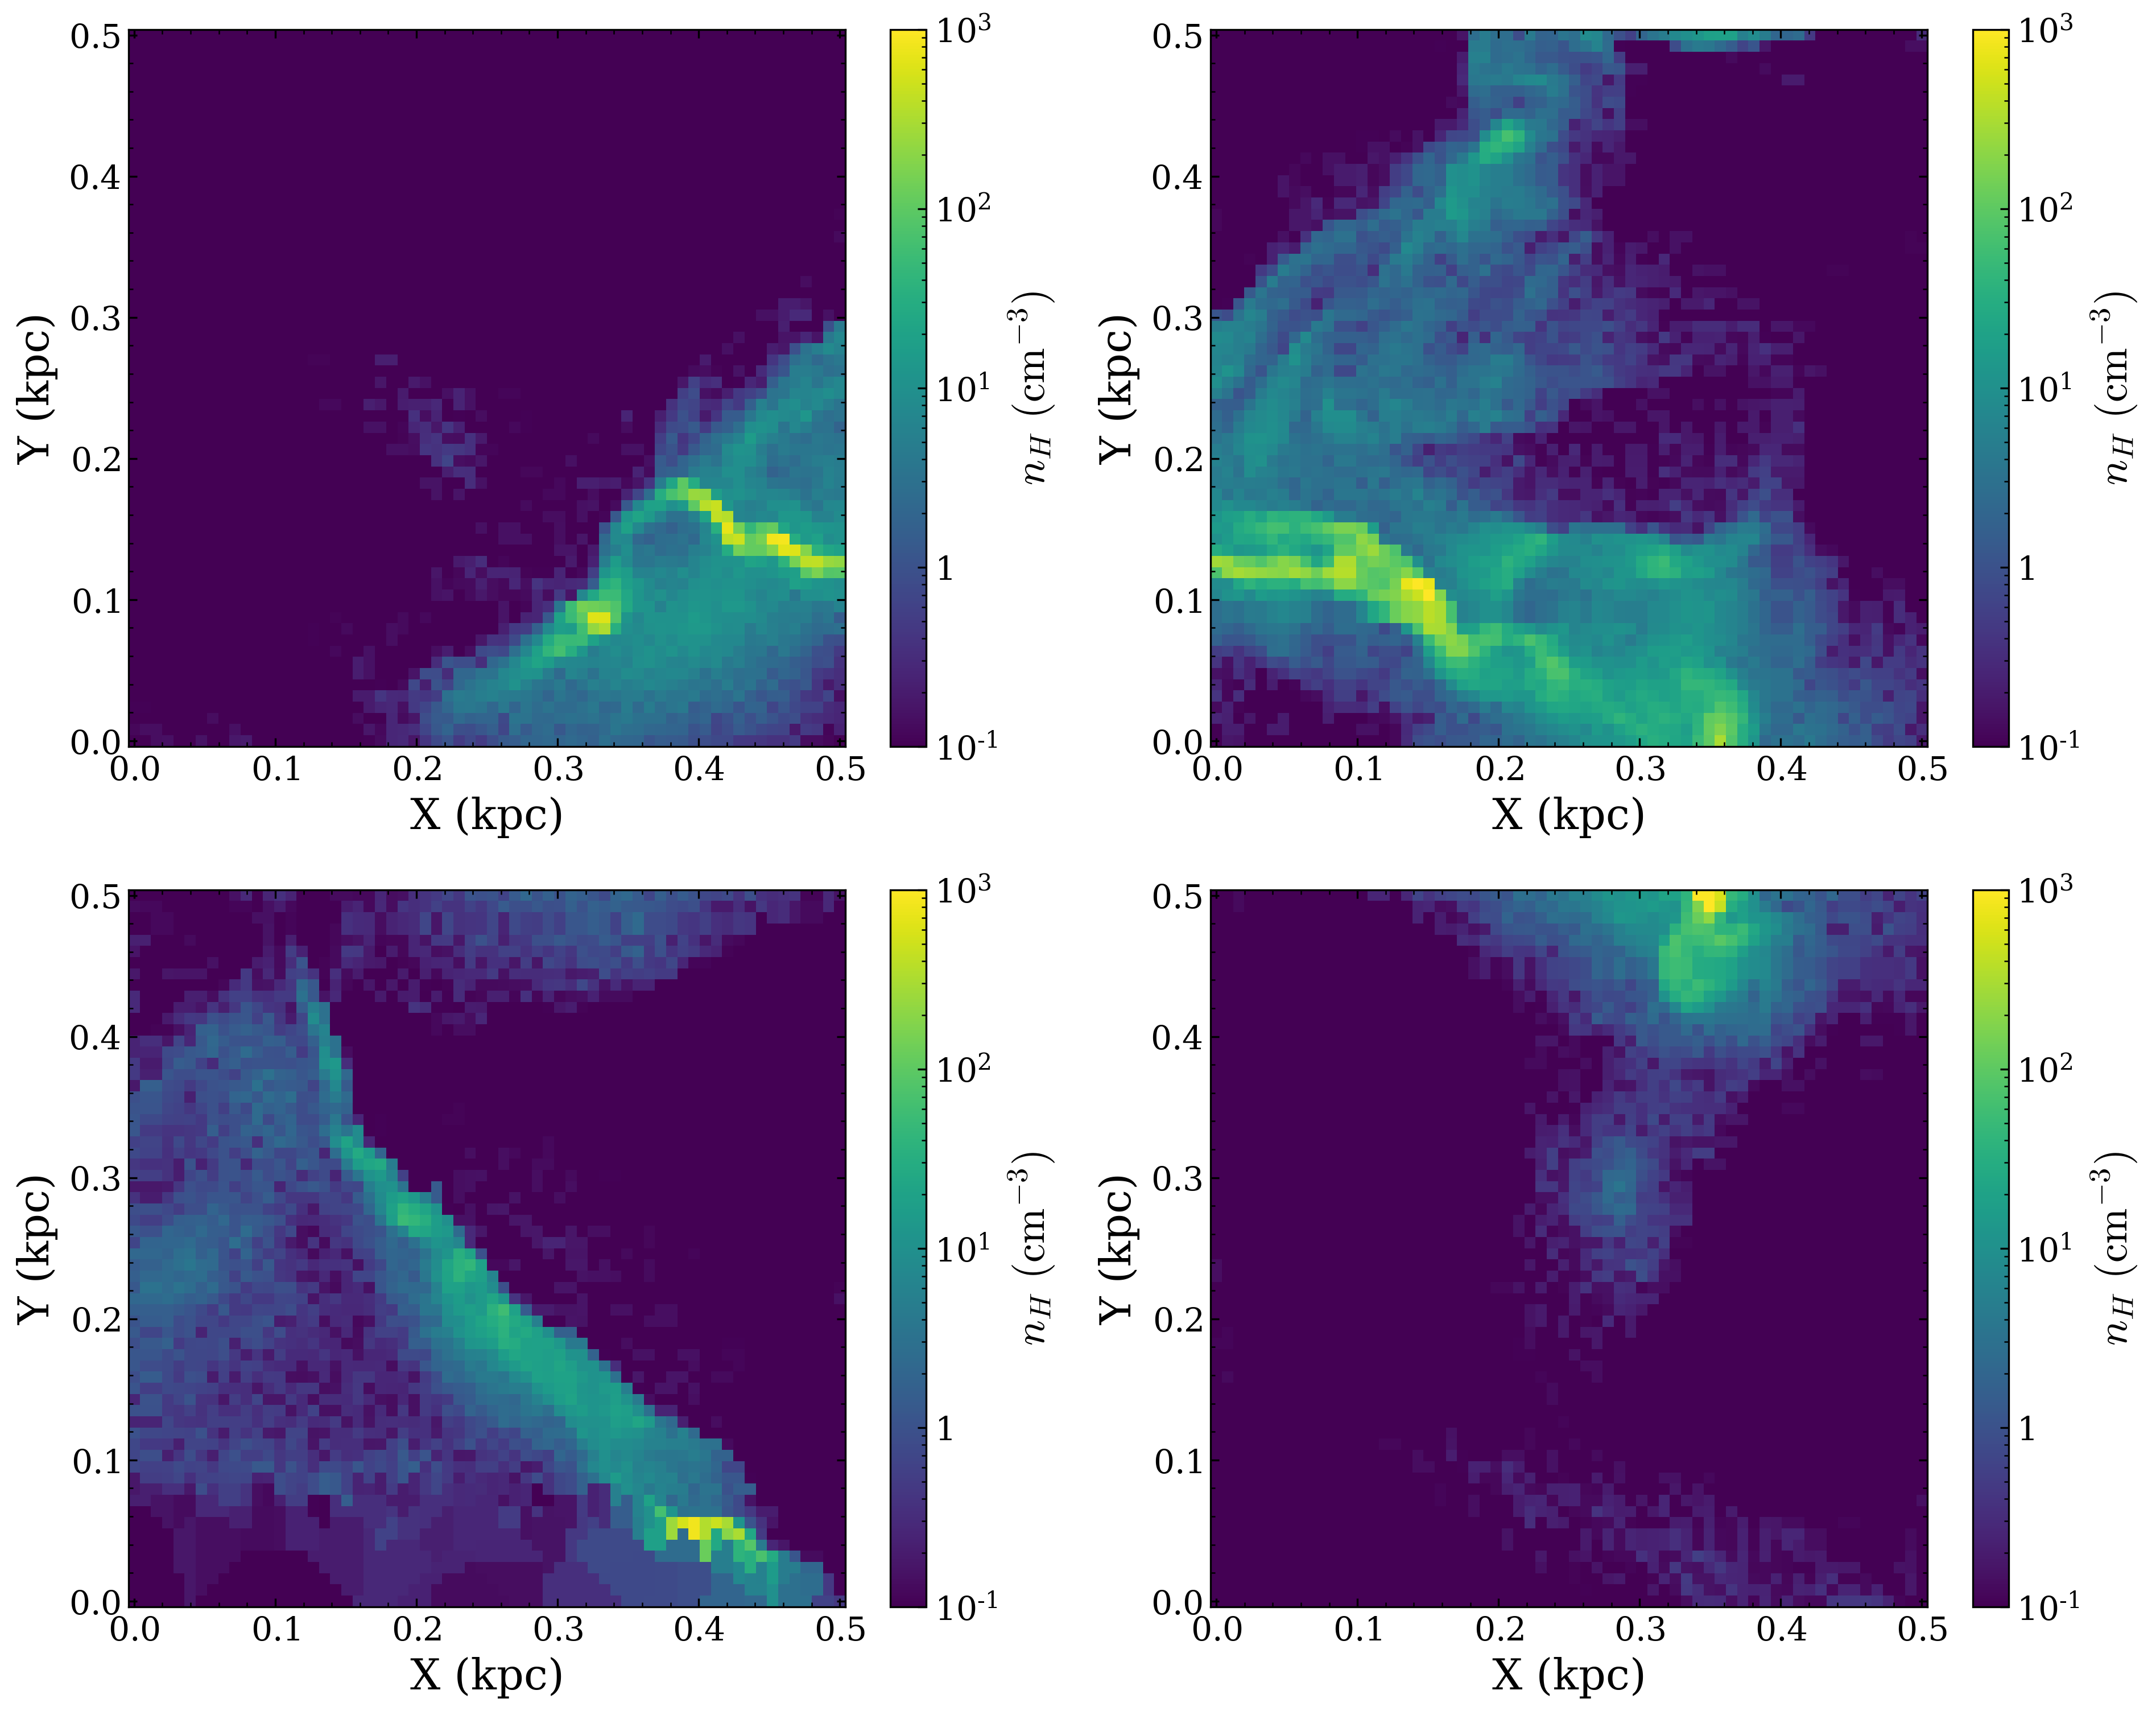

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
blocksDecomp[0,0,0].plot_density_slice(index=32, axis=2, ax=ax[1,0])
blocksDecomp[1,0,0].plot_density_slice(index=32, axis=2, ax=ax[0,0])
blocksDecomp[0,1,0].plot_density_slice(index=32, axis=2, ax=ax[1,1])
blocksDecomp[1,1,0].plot_density_slice(index=32, axis=2, ax=ax[0,1])
plt.show()

In [30]:
simField = simParticles.interp_to_field(Nsize=128, eps=0.2)

Interpolating velocity field...
Box length: 1.0, box size: 128


Data file saved.
Query file saved.



real	0m8.647s
user	0m8.374s
sys	0m0.148s


Approximate Nearest Neighbour complete. Time taken: 8.69 s.
Interpolation done. Time elapsed: 41.41 s


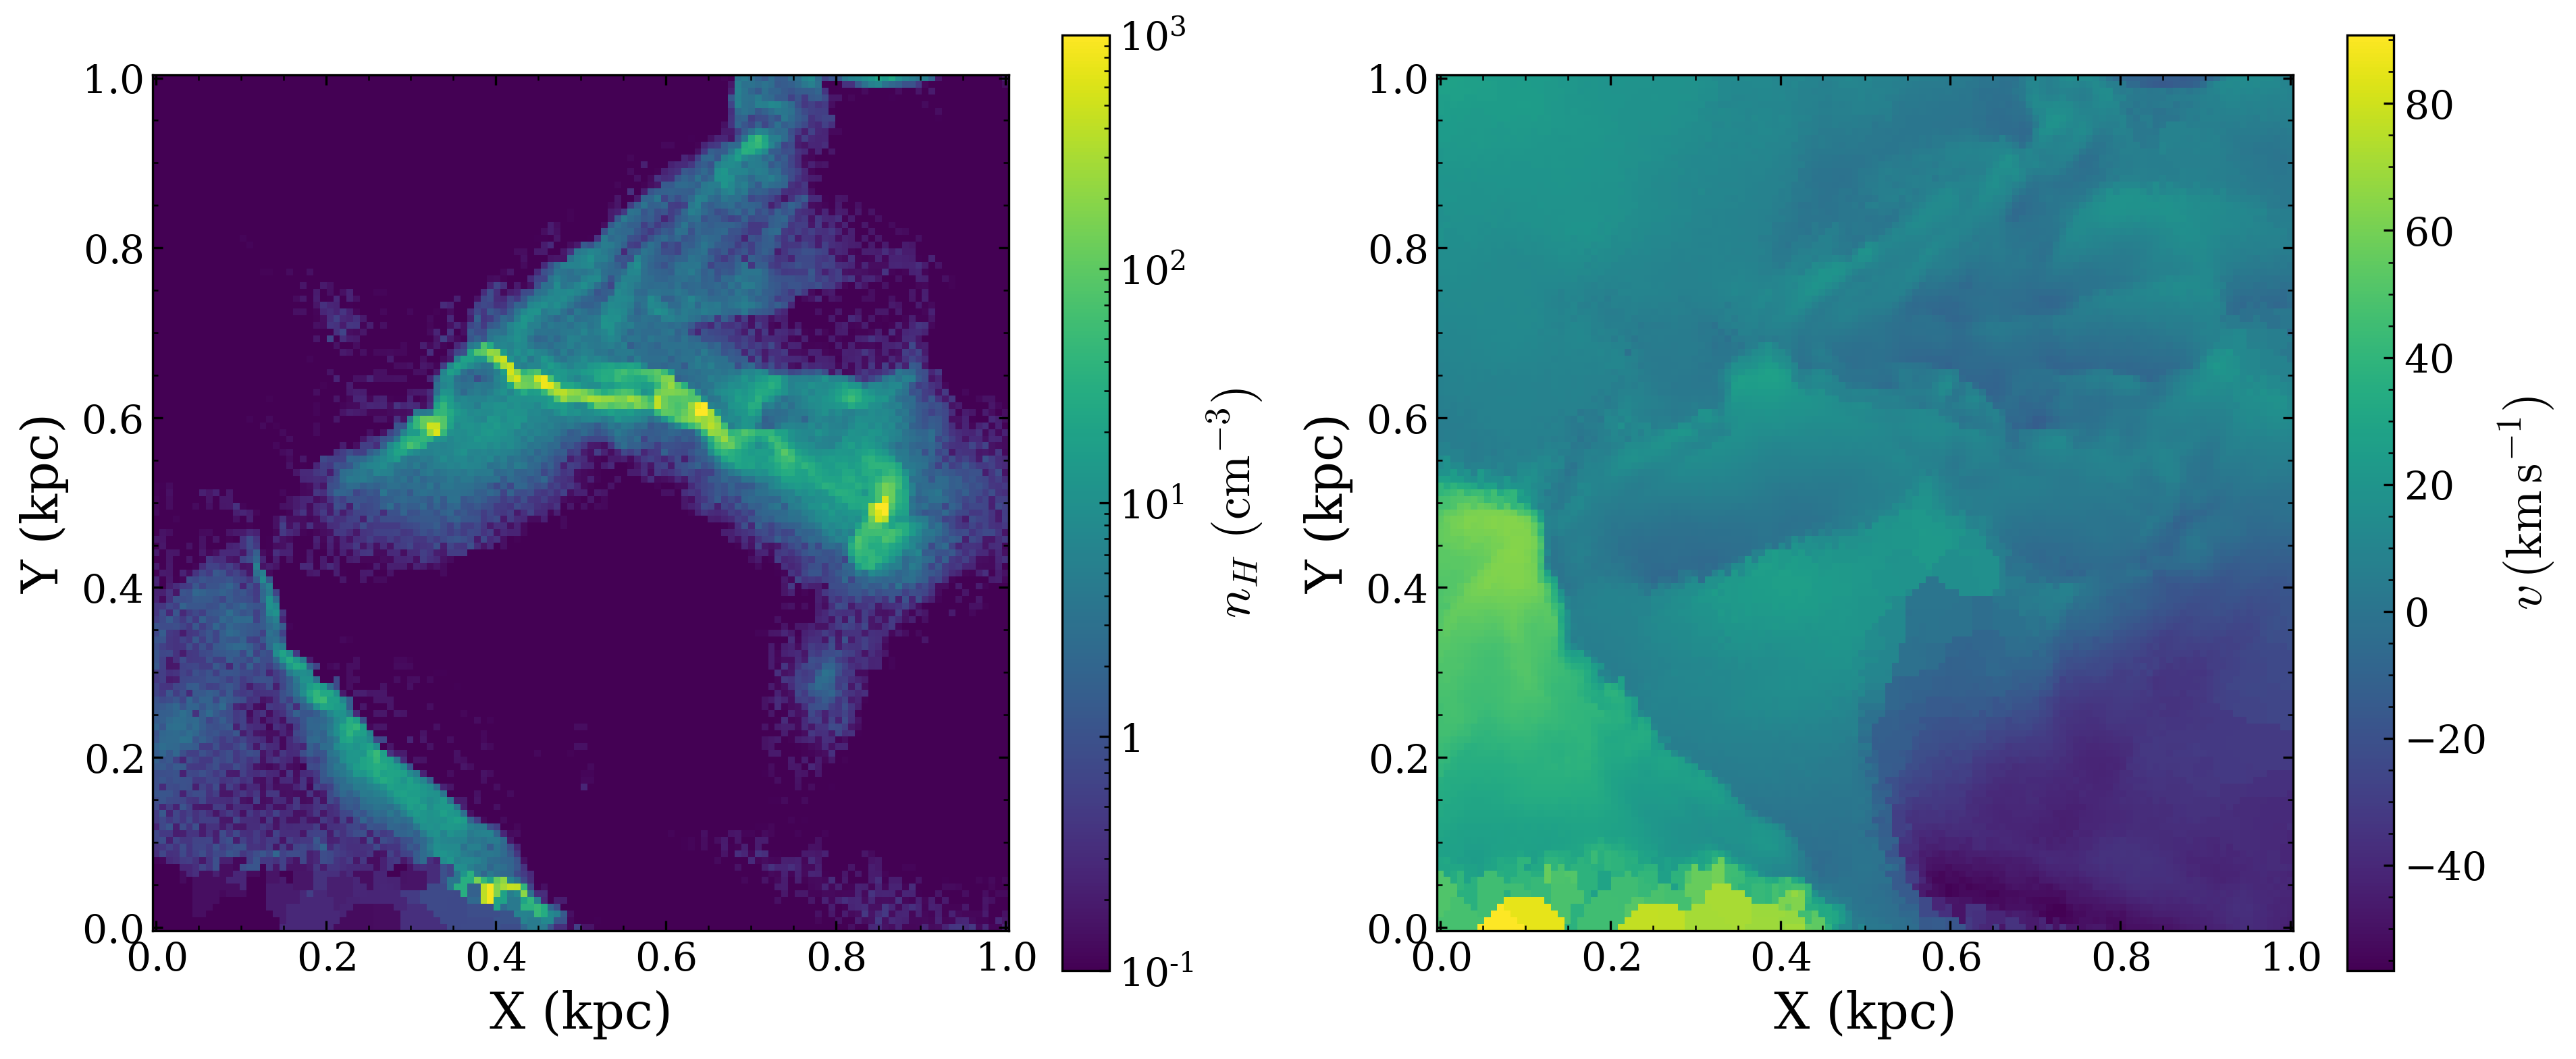

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simField.plot_density_slice(index=32, axis=2, ax=ax[0])
simField.plot_velocity_slice(component=0, index=32, axis=2, ax=ax[1])
plt.show()